### Movies Dataset EDA and Output Preprocessed Files

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

### Load Raw Data

In [4]:
movies = pd.read_csv('./data/movies.csv')
movies.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [14]:
ratings = pd.read_csv('./data/ratings.csv')
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [21]:
### User Input Tags
tags = pd.read_csv('./data/tags.csv')
tags.tag = tags.tag.astype(str)
tags.shape

(1093360, 4)

In [19]:
genomeTags = pd.read_csv('./data/genome-tags.csv')
genomeTags.shape

(1128, 2)

In [20]:
genomeScores = pd.read_csv('./data/genome-scores.csv')
genomeScores.shape

(15584448, 3)

### Movies Database 

#### Feature Engineering 
#### Extract and Categorize Release Dates to Movie Eras

In [5]:
releaseYr = []
for i in movies.title:
    try:
        releaseYr.append(re.search('\((\d\d\d\d)\)',i).group(1))
    except: releaseYr.append('2015') # assign to yr with large num releases to not skew other data
len(releaseYr)

62423

In [6]:
movies['releaseYr'] = pd.DataFrame(releaseYr)

In [7]:
movies.releaseYr = pd.to_datetime(movies.releaseYr)
movies.releaseYr = movies.releaseYr.dt.year

In [8]:
# 15036, 26284, 62104, 62380
movies.releaseYr[62380]  # movies with no release date info assigned to 2015, 410 out of 2923 values

2015

<AxesSubplot:>

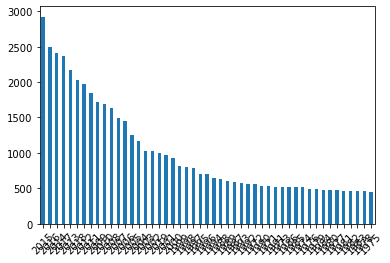

In [293]:
#movies[movies.releaseYr !=0].releaseYr.value_counts()[::-1].plot.area(rot=45)
movies[movies.releaseYr > 1970].releaseYr.value_counts().plot.bar(rot=45)

In [9]:
# Movie Eras defined in: http://www.historyoffilm.net/movie-eras/history-of-cinema/

bins = [0,1910,1926,1940,1954,1976,1999,3000]
labels = ['Pioneer', 'Silent', 'Studio', 'Golden', 'Change', 'Blockbuster', 'Modern']
movies['era'] = pd.cut(movies.releaseYr, bins=bins, labels=labels, right=False)
movies

,movieId,title,genres,releaseYr,era
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Blockbuster
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Blockbuster
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Blockbuster
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,Blockbuster
4,5,Father of the Bride Part II (1995),Comedy,1995,Blockbuster
...,...,...,...,...,...
62418,209157,We (2018),Drama,2018,Modern
62419,209159,Window of the Soul (2001),Documentary,2001,Modern
62420,209163,Bad Poems (2018),Comedy|Drama,2018,Modern
62421,209169,A Girl Thing (2001),(no genres listed),2001,Modern


<AxesSubplot:>

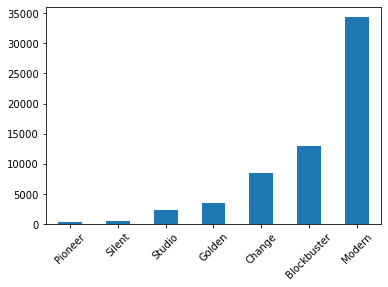

In [295]:
movies.era.value_counts()[::-1].plot.bar(rot=45)

In [10]:
# OneHotEncode 'era' col
movies = pd.concat([movies, pd.get_dummies(movies.era, drop_first=True)], axis=1)

#### Extract Genres

In [11]:
# OneHotEncode 'genres' col
genres = [i.split("|") for i in movies['genres'].unique()]
columns = list(set([i for genre in genres for i in genre]))
columns.remove('(no genres listed)')  # equiv to conducting a 'drop_first'

for col in columns:
    movies[col] = movies['genres'].apply(lambda x: 1 if col in x else 0)

In [12]:
movies.shape

(62423, 30)

In [310]:
# Visualizing sparse matrix

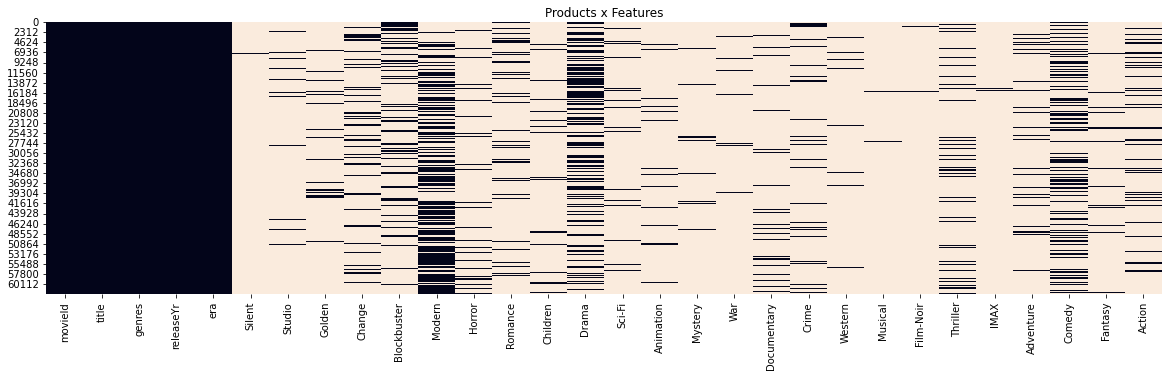

In [160]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(movies==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Products x Features")
plt.show()

#### Adding Avg User Assigned Ratings 

In [18]:
# Getting mean ratings per movie
movies = movies.merge(pd.DataFrame(ratings.groupby('movieId').rating.mean()), how='left', left_on='movieId', right_index=True)
movies.shape

(62423, 31)

In [112]:
# Make ratings bins

movies['ratingBins'], cut_bin = pd.qcut(movies.rating, q = 3, labels = ['belowAvg', 'Avg', 'aboveAvg'], retbins = True)
movies.ratingBins = movies.ratingBins.astype(str)

#### Add User Tags 

In [86]:
# run code below for user tags first
movies = movies.merge(userTags, how='left', on='movieId')
movies.userTag = movies.userTag.fillna('')
movies.head()

,movieId,title,genres,releaseYr,era,Silent,Studio,Golden,Change,Blockbuster,...,Western,Adventure,Documentary,IMAX,Crime,War,Horror,Animation,rating,userTag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Blockbuster,0,0,0,0,1,...,0,1,0,0,0,0,0,1,3.893708,Owned imdb top 250 Pixar Pixar time travel chi...
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Blockbuster,0,0,0,0,1,...,0,1,0,0,0,0,0,0,3.251527,Robin Williams time travel fantasy based on ch...
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Blockbuster,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3.142028,funny best friend duringcreditsstinger fishing...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,Blockbuster,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2.853547,based on novel or book chick flick divorce int...
4,5,Father of the Bride Part II (1995),Comedy,1995,Blockbuster,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3.058434,aging baby confidence daughter gynecologist mi...


#### Genres as String Value

In [87]:
movies['genreStr'] = movies.genres.str.replace('|',' ').replace('(no genres listed)','')
movies.head()

C:\Users\kforkai\AppData\Local\Temp\ipykernel_37404\4130110011.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['genreStr'] = movies.genres.str.replace('|',' ').replace('(no genres listed)','')


,movieId,title,genres,releaseYr,era,Silent,Studio,Golden,Change,Blockbuster,...,Adventure,Documentary,IMAX,Crime,War,Horror,Animation,rating,userTag,genreStr
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Blockbuster,0,0,0,0,1,...,1,0,0,0,0,0,1,3.893708,Owned imdb top 250 Pixar Pixar time travel chi...,Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Blockbuster,0,0,0,0,1,...,1,0,0,0,0,0,0,3.251527,Robin Williams time travel fantasy based on ch...,Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Blockbuster,0,0,0,0,1,...,0,0,0,0,0,0,0,3.142028,funny best friend duringcreditsstinger fishing...,Comedy Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,Blockbuster,0,0,0,0,1,...,0,0,0,0,0,0,0,2.853547,based on novel or book chick flick divorce int...,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,1995,Blockbuster,0,0,0,0,1,...,0,0,0,0,0,0,0,3.058434,aging baby confidence daughter gynecologist mi...,Comedy


#### Movie Titles Without Year

In [88]:
titleClean = []

for i in movies.title:
    try: 
        titleClean.append(re.search('(.+)[^\((\d\d\d\d)\)]',i).group(1))
    except: pass

len(titleClean)

62423

In [89]:
movies['movieName'] = pd.DataFrame(titleClean)
movies.head()

,movieId,title,genres,releaseYr,era,Silent,Studio,Golden,Change,Blockbuster,...,Documentary,IMAX,Crime,War,Horror,Animation,rating,userTag,genreStr,movieName
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Blockbuster,0,0,0,0,1,...,0,0,0,0,0,1,3.893708,Owned imdb top 250 Pixar Pixar time travel chi...,Adventure Animation Children Comedy Fantasy,Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Blockbuster,0,0,0,0,1,...,0,0,0,0,0,0,3.251527,Robin Williams time travel fantasy based on ch...,Adventure Children Fantasy,Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Blockbuster,0,0,0,0,1,...,0,0,0,0,0,0,3.142028,funny best friend duringcreditsstinger fishing...,Comedy Romance,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,Blockbuster,0,0,0,0,1,...,0,0,0,0,0,0,2.853547,based on novel or book chick flick divorce int...,Comedy Drama Romance,Waiting to Exhale
4,5,Father of the Bride Part II (1995),Comedy,1995,Blockbuster,0,0,0,0,1,...,0,0,0,0,0,0,3.058434,aging baby confidence daughter gynecologist mi...,Comedy,Father of the Bride Part II


#### Movies Supertext

In [116]:
#movies['text'] = pd.Series(movies.movieName[0] + ' ' + movies.era[0] + ' ' + movies.ratingBins[0] + ' ' + movies.genreStr[0] + ' ' + movies.userTag[0])

# Version without movie name
movies['text'] = pd.Series(movies.era.astype(str) + ' ' + movies.ratingBins + ' ' + movies.genreStr + ' ' + movies.userTag)

In [118]:
moviesSuper = movies[['movieId','movieName','genres','releaseYr','rating','text']]

In [119]:
moviesSuper.to_csv('./data/moviesSuper.csv')

### User Ratings

In [15]:
# convert timestamp to date
ratings.timestamp = ratings.timestamp.apply(lambda x: datetime.date.fromtimestamp(x))

In [16]:
# comment year
ratings['year'] = pd.to_datetime(ratings.timestamp).dt.year

In [17]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
 4   year       int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 953.7+ MB


In [167]:
# extract superuser userIds into a list
superThreshold = 1000 

superList = [k for k,v in pd.Series.to_dict(ratings.userId.value_counts() >= superThreshold).items() if v == True]
len(superList)

2675

In [168]:
# Build superusers dataset
ratingsSlim = ratings[ratings.userId.isin(superList)]
ratingsSlim.shape

(4192357, 6)

In [169]:
ratingsSlim

,userId,movieId,rating,timestamp,year,weights
23893,187,1,3.5,2010-06-24,2010,NaN
23894,187,2,3.5,2010-06-24,2010,NaN
23895,187,3,3.0,2010-06-30,2010,NaN
23896,187,13,4.5,2010-06-24,2010,NaN
23897,187,19,4.5,2010-06-24,2010,NaN
...,...,...,...,...,...,...
24996318,162516,194947,3.5,2019-02-25,2019,15.895427
24996319,162516,194951,4.0,2018-12-26,2018,17.327529
24996320,162516,195159,3.5,2019-10-14,2019,15.895427
24996321,162516,196997,3.5,2019-01-01,2019,15.895427


#### Downsample to 5Y worth of ratings data 

In [132]:
dict(ratingsSlim[ratingsSlim.year > 2014].year.value_counts(normalize=True)*100)

{2017: 22.840084503297405,
 2016: 21.792299060521422,
 2015: 20.190441147284105,
 2018: 17.732272232677673,
 2019: 17.444903056219392}

In [139]:
# Resample ratings population according to year weights
sample_size = 200000
yearStart = 2014

ratingsSlim['weights'] = ratingsSlim.year.map(dict(ratingsSlim[ratingsSlim.year > yearStart].year.value_counts(normalize=True)*100))
ratingsWgt = ratingsSlim.sample(n=sample_size, weights='weights')

C:\Users\kforkai\AppData\Local\Temp\ipykernel_29352\2222255371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratingsRed['weights'] = ratingsRed.year.map(dict(ratingsRed[ratingsRed.year > 2014].year.value_counts(normalize=True)*100))


In [171]:
# Write to csv
ratingsWgt.to_csv('./data/ratingsSuper.csv')

In [140]:
# sampling 100K user ratings
print(len(set(ratingsWgt.userId)),len(set(ratingsWgt.movieId)), sep=', ' )

1586, 26047


In [141]:
# 8Gb RAM operation
ratingsPv = pd.pivot_table(ratingsWgt.iloc[:,0:3], index='userId', columns='movieId', values='rating')

In [136]:
ratingsPv

movieId,1,2,3,4,5,6,7,8,9,10,...,207796,207830,207882,208096,208148,208199,208507,208737,208767,209057
userId,,,,,,,,,,,,,,,,,,,,,
187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161675,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


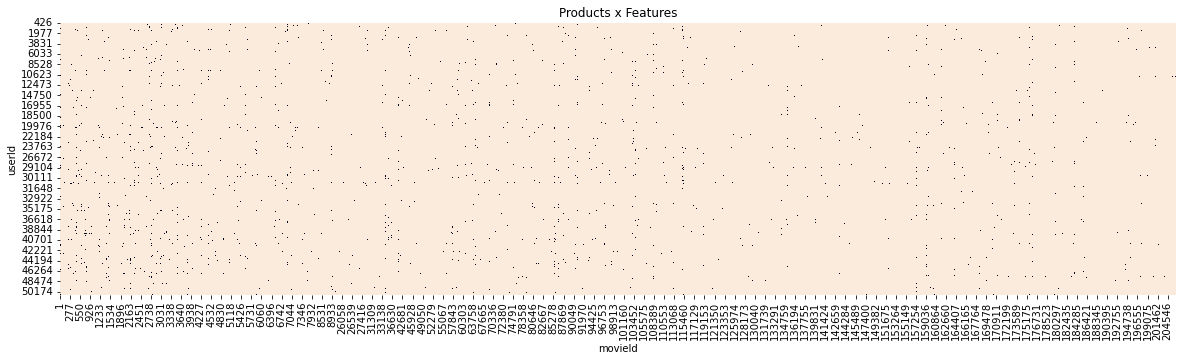

In [142]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(ratingsPv.iloc[:500,:].isnull(), cbar=False, ax=ax).set_title("Products x Features")
plt.show()

In [170]:
# Write to csv, also uses significant RAM
ratingsPv.to_csv('./data/ratingsPvSuper.csv')

In [173]:
# movie titles contained in reduced list 
moviesWgt = list(set(ratingsWgt.movieId))

In [174]:
moviesSlim = movies[movies.movieId.isin(moviesWgt)]
moviesSlim.shape

(26047, 30)

<AxesSubplot:>

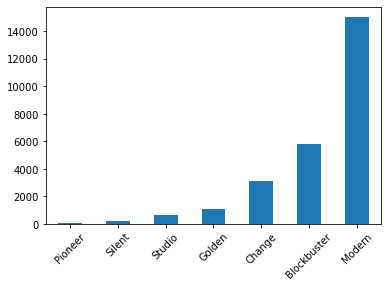

In [175]:
moviesSlim.era.value_counts()[::-1].plot.bar(rot=45)

In [176]:
# Write to csv
moviesSlim.to_csv('./data/moviesSuper.csv')

###  Genome Scores

In [54]:
# Downsample genome scores
genomeScores100 = genomeScores[genomeScores.movieId.isin(moviesWgt)]
genomeScores100.shape

(9513552, 3)

In [56]:
pd.pivot(genomeScores100, index='movieId', columns='tagId', values='relevance')

tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.20200,0.03075,...,0.04050,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200
2,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.07650,0.05250,...,0.05250,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975
3,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.02850,0.03875,...,0.06275,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775
4,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.03200,0.03150,...,0.05325,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500
5,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.02150,0.02975,...,0.05350,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205072,0.02050,0.01775,0.11400,0.03650,0.31225,0.03675,0.10700,0.37925,0.01725,0.36350,...,0.18675,0.03650,0.03025,0.12900,0.13975,0.42425,0.03400,0.02350,0.41725,0.09100
205076,0.03825,0.03150,0.03200,0.05325,0.20850,0.07050,0.06625,0.27825,0.00950,0.02750,...,0.27775,0.03225,0.04675,0.03175,0.23025,0.06300,0.04175,0.04125,0.07275,0.02350
205383,0.04100,0.04025,0.02750,0.07850,0.19750,0.17825,0.17125,0.30475,0.16825,0.04850,...,0.16525,0.03250,0.02400,0.03575,0.20400,0.08525,0.04600,0.02900,0.11725,0.03925


### User Input Tags 

In [83]:
tags.shape, len(set(tags.movieId))

((1093360, 4), 45251)

In [81]:
# make a list of tags
n = 5  # at least this number of occurences
tagsList = pd.Series.to_list(tags.tag.value_counts().loc[lambda x : x >= n].to_frame().reset_index().rename(columns={'index':'userTag'}).userTag)
len(tagsList)

18094

In [82]:
tagsSlim = tags[tags.tag.isin(tagsList)]
tagsSlim.shape, len(set(tagsSlim.movieId))

((1007414, 4), 44143)

#### Feature Engineering: Merge all tags

In [121]:
# lower case, split by space
tagsSlim = tagsSlim.merge(pd.DataFrame(tagsSlim.groupby('movieId').tag.transform(lambda x : ' '.lower().join(x))).rename(columns={'tag':'userTag'}), how='left', left_index=True, right_index=True)
tagsSlim.head()

,userId,movieId,tag,timestamp,userTag
0,3,260,classic,1439472355,classic sci-fi action adventure fantasy space ...
1,3,260,sci-fi,1439472256,classic sci-fi action adventure fantasy space ...
2,4,1732,dark comedy,1573943598,dark comedy great dialogue imdb top 250 bowlin...
3,4,1732,great dialogue,1573943604,dark comedy great dialogue imdb top 250 bowlin...
4,4,7569,so bad it's good,1573943455,so bad it's good asia assassin assassination b...


In [85]:
userTags = tagsSlim[['movieId','userTag']].drop_duplicates()
len(userTags)

44143